In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import tqdm
import functools
import sys

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages


import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

2025-06-01 10:05:24.225439: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 10:05:24.245683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
sys.path.append('../../')
from consensus_variables import *

In [4]:
# path with mutations

deepCSA_folder = deepcsa_run_dir

In [5]:
PROTEIN_AFFECTING_SET = {
    'nonsense',
    'missense',
    'essential_splice',
    'protein_altering_variant',
    'transcript_amplification',
}

# load mutations

In [6]:
precomputed_rates_dir = "../../data/saturation_kinetics"

In [7]:
# mutations_genomic = pd.read_csv(f'{precomputed_rates_dir}/mutations_genomic_rates.tsv', sep='\t')
mutations_genomic = None

In [8]:
mutations_residue = pd.read_csv(f'{precomputed_rates_dir}/mutations_residue_rates.tsv', sep='\t')

In [9]:
mutations_residue.head()

,GENE,RESIDUE,ALT_DEPTH,DEPTH,UNIQUE_RATE_0,UNIQUE_RATE_1,UNIQUE_RATE_2,UNIQUE_RATE_3,UNIQUE_RATE_4,UNIQUE_RATE_5,...,UNIQUE_RATE_10,UNIQUE_RATE_11,UNIQUE_RATE_12,UNIQUE_RATE_13,UNIQUE_RATE_14,UNIQUE_RATE_15,UNIQUE_RATE_16,UNIQUE_RATE_17,UNIQUE_RATE_18,UNIQUE_RATE_19
0,ARID1A,*2286,2,359682.0,0.019896,0.025179,0.031859,0.040283,0.050908,0.064290,...,0.202184,0.252347,0.313581,0.387421,0.474958,0.576196,0.688927,0.806790,0.916023,0.990000
1,ARID1A,A1029,1,516558.0,0.009999,0.012670,0.016058,0.020348,0.025788,0.032678,...,0.106793,0.135332,0.171497,0.217325,0.275402,0.348997,0.442260,0.560444,0.710211,0.900000
2,ARID1A,A1035,1,504621.0,0.010000,0.012671,0.016058,0.020350,0.025788,0.032678,...,0.106793,0.135331,0.171497,0.217325,0.275401,0.348997,0.442259,0.560444,0.710210,0.899998
3,ARID1A,A1043,1,499857.0,0.009999,0.012672,0.016059,0.020350,0.025787,0.032679,...,0.106793,0.135333,0.171497,0.217326,0.275401,0.348998,0.442258,0.560444,0.710211,0.899999
4,ARID1A,A1077,6,592771.0,0.058513,0.073658,0.092565,0.116046,0.145086,0.180736,...,0.492179,0.582079,0.676582,0.770131,0.855263,0.923881,0.969899,0.992788,0.999408,0.999999


# compute empirical discovery index curves per gene

In [10]:
from discovery import collect_vep, load_panel

vep = collect_vep()
df_panel = load_panel(vep)

In [11]:
# df_panel represents the total number of mutable sites,
# either genomic or residue sites

df_panel.head()

,CHROM,POS,REF,ALT,MUT_ID,GENE,IMPACT,CONTEXT_MUT,CONTEXT,DEPTH,AACHANGE,SYMBOL,RESIDUE
51,chr1,26729651,C,A,chr1_26729651_C/A,ARID1A,missense,GCC>A,GCC,443650,P380T,ARID1A,P380
52,chr1,26729651,C,G,chr1_26729651_C/G,ARID1A,missense,GCC>G,GCC,443650,P380A,ARID1A,P380
53,chr1,26729651,C,T,chr1_26729651_C/T,ARID1A,missense,GCC>T,GCC,443650,P380S,ARID1A,P380
54,chr1,26729652,C,A,chr1_26729652_C/A,ARID1A,missense,CCA>A,CCA,443883,P380Q,ARID1A,P380
55,chr1,26729652,C,G,chr1_26729652_C/G,ARID1A,missense,CCA>G,CCA,443883,P380R,ARID1A,P380


In [12]:
df_panel_genomic = df_panel.groupby(['POS', 'GENE']).agg({'DEPTH': 'mean'}).reset_index()
df_panel_residue = df_panel.groupby(['RESIDUE',  'GENE']).agg({'DEPTH': 'mean'}).reset_index()

In [13]:
df_panel_dict = {
    'genomic': df_panel_genomic,
    'residue': df_panel_residue
    }

mutations_dict = {
    'genomic': mutations_genomic,
    'residue': mutations_residue
}

In [14]:
subsampling_rates = np.logspace(-2, np.log10(0.9), num=20)

def empirical_discovery_index_curve(gene, replicates=100, sites='genomic'):

    df = mutations_dict[sites]
    df = df[df['GENE'] == gene]

    dg = df_panel_dict[sites]
    dg = dg[dg['GENE'] == gene]

    size = dg.shape[0]
    mean_depth = df['DEPTH'].mean()
    
    x, mean, err_low, err_high = [], [], [], []
    
    unique_dict = {}
    for i, p in tqdm.tqdm(enumerate(subsampling_rates)):
        dist_bernoulli = tfd.Bernoulli(probs=df[f'UNIQUE_RATE_{i}'].values)
        unique_mutations = np.sum(dist_bernoulli.sample(sample_shape=(100,)), axis=1)
        y = list(unique_mutations / size)
        mean += [np.mean(y)]
        err_low += [np.percentile(y, 2.5)]
        err_high += [np.percentile(y, 97.5)]
        x += [mean_depth * p]
    mean += [df.shape[0] / size]
    err_low += [df.shape[0] / size]
    err_high += [df.shape[0] / size]
    x += [mean_depth]

    return x, mean, err_low, err_high

In [15]:
def plot_empirical_discovery(gene):
    x, mean, err_low, err_high = empirical_discovery_index_curve(gene, sites='residue')
    plt.scatter(x, mean, s=50)
    for i, m in enumerate(x):
        plt.vlines(m, err_low[i], err_high[i])
    plt.xscale('log')
    plt.title(gene)
    plt.show()

# theoretical neutral vs empirical discovery curves

In [16]:
# Create a PDF to save the plots
def main_empirical(sample, sites='genomic', logscale=False, genes_list = None):

    mutations_lite = mutations_dict[sites]
    mutations_lite['VAF'] = mutations_lite.apply(lambda r: r['ALT_DEPTH']/r['DEPTH'], axis=1)

    df_panel = pd.read_csv(os.path.join(deepCSA_folder, 'createpanels', 'consensuspanels', 'consensus.exons_splice_sites.tsv'), sep='\t')

    # include depth per site

    df_depth = pd.read_csv(os.path.join(deepCSA_folder, 'annotatedepths', f'{sample}.depths.annotated.tsv.gz'), sep='\t')
    df_panel = pd.merge(df_panel, df_depth[['CHROM', 'POS', sample]], on=['CHROM', 'POS'], how='left')
    df_panel.rename(columns={sample: 'DEPTH'}, inplace=True)

    # retrieve relative mutability
    mutability_raw = pd.read_csv(os.path.join(deepCSA_folder, 'mutability', f'{sample}.all.adjusted.gz'), 
                                    sep='\t', header=None, names=['CHROM', 'POS', 'REF', 'ALT', 'MUTABILITY'])
    mutability_raw = pd.merge(mutability_raw, df_panel, on=['CHROM', 'POS', 'REF', 'ALT'], how='left')

    # collect VEP annotations

    df_panel = pd.merge(df_panel, vep[['CHROM', 'POS', 'REF', 'ALT', 'AACHANGE', 'SYMBOL']], 
                              left_on=['CHROM', 'POS', 'REF', 'ALT', 'GENE'], 
                              right_on=['CHROM', 'POS', 'REF', 'ALT', 'SYMBOL'],
                              how='left')

    if genes_list is None:
        genes_list = df_panel['GENE'].unique()

    for gene in tqdm.tqdm(genes_list):

        try:

            synonymous_mutation_rate = pd.read_csv(os.path.join(deepCSA_folder, 'omega', 'preprocessing', f'mutability_per_sample_gene_context.{sample}.tsv'), sep='\t')
            synonymous_mutation_rate = synonymous_mutation_rate[synonymous_mutation_rate['GENE'] == gene]

            mutability_gene = mutability_raw[mutability_raw['GENE'] == gene]
            mutability_gene = pd.merge(mutability_gene, synonymous_mutation_rate[['CONTEXT_MUT', 'all_samples']], on=['CONTEXT_MUT'], how='left')
            mutability_gene.rename(columns={'all_samples': 'MUTRATE'}, inplace=True)

            mutability_gene = pd.merge(mutability_gene, df_panel[['CHROM', 'POS', 'REF', 'ALT', 'AACHANGE']], on=['CHROM', 'POS', 'REF', 'ALT'], how='left')

            # discard positions in non-CDS regions, probably splicing and intronic
            mutability_gene = mutability_gene[(mutability_gene['AACHANGE'] != '-') & (~mutability_gene['AACHANGE'].isnull())]

            # keep only protein affecting mutation sites
            mutability_gene = mutability_gene[mutability_gene["IMPACT"].isin(PROTEIN_AFFECTING_SET)]

            mutability_gene['RESIDUE'] = mutability_gene['AACHANGE'].apply(lambda s: s[:-1])

            if sites == 'residue':
                mutability_gene = mutability_gene.groupby(['GENE', 'RESIDUE']).agg({'MUTRATE': 'sum', 'DEPTH': 'mean'}).reset_index()
            elif sites == 'genomic':
                mutability_gene = mutability_gene.groupby(['GENE', 'POS']).agg({'MUTRATE': 'sum', 'DEPTH': 'mean'}).reset_index()
            
            mutability_gene['MUTABILITY'] = mutability_gene.apply(lambda s: (s['MUTRATE'] / s['DEPTH']), axis=1)

            if sites == 'residue':
                mutability_gene = pd.merge(mutability_gene, mutations_lite[['GENE', 'RESIDUE', 'VAF']], on=['GENE', 'RESIDUE'], how='left')
            elif sites == 'genomic':
                mutability_gene = pd.merge(mutability_gene, mutations_lite[['GENE', 'POS', 'VAF']], on=['GENE', 'POS'], how='left')


            # neutral rate
            mutability_gene['RATE_NEUTRAL'] = mutability_gene['MUTABILITY']
            total_neutral_rate = mutability_gene['RATE_NEUTRAL'].sum()

            # compute saturation theoretical
            y_unique_neutral = []
            if sites == 'genomic':
                x_theoretical = np.logspace(3, 8, num=100)
            elif sites == 'residue':
                x_theoretical = np.logspace(3, 7, num=100)

            for depth in x_theoretical:
                unique_neutral = np.sum(1 - np.exp(-mutability_gene['RATE_NEUTRAL'].values * depth)) / mutability_gene.shape[0]
                y_unique_neutral.append(unique_neutral)

            # compute empirical discovery index curve

            x_empirical, mean, err_low, err_high = empirical_discovery_index_curve(gene, sites=sites)

            # plot

            fig, ax1 = plt.subplots(figsize=(2,2))
            ax1.set_xscale('log')
            if logscale:
                ax1.set_yscale('log')

            # empirical

            ax1.scatter(x_empirical[:-1], mean[:-1], label='downsampling', color='brown', s=5)
            ax1.scatter(x_empirical[-1], mean[-1], label='observed', color='white', edgecolors='brown', alpha=1, s=100)
            for i, m in enumerate(x_empirical[:-2]):
                plt.vlines(m, err_low[i], err_high[i], color='brown', lw=1)

            # theoretical

            ax1.plot(x_theoretical, y_unique_neutral, color='grey', lw=2, label='neutral theoretical', alpha=0.5)  # neutral
            # ax1.tick_params(axis='y', labelcolor=color)
            if sites == 'residue':
                ax1.set_ylabel('proportion of\nmutated residues')
            elif sites == 'genomic':
                ax1.set_ylabel('proportion of\nmutated nucleotides')
            
            ax1.set_xlabel('depth per residue')
            # ax1.vlines(5e5, 0, 1., linestyles='dashed', color='maroon', label='cohort', alpha=0.3)

            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)

            ax1.set_xlim(x_theoretical[0], x_theoretical[-1])

            # ax1.legend(loc=(1,0))

            plt.title(gene)

            if logscale:
                plt.savefig(f'plot/saturationkinetics/propotion_mutated_sites_{sites}_logscale_{gene}.png', bbox_inches='tight', dpi=300)
            else:
                plt.savefig(f'plot/saturationkinetics/propotion_mutated_sites_{sites}_{gene}.png', bbox_inches='tight', dpi=300)

            plt.show()

        except:

            print(gene)
            continue

In [17]:
mutations_residue["GENE"].unique()

array(['ARID1A', 'BMP2K', 'CDKN1A', 'CREBBP', 'EP300', 'FGFR1', 'FGFR3',
       'FGFR4', 'FOXL1', 'FOXQ1', 'JPH3', 'KDM6A', 'KMT2C', 'KMT2D',
       'MAGI1', 'MAML2', 'MN1', 'NCOA3', 'NCOA6', 'NOTCH2', 'PIK3CA',
       'RB1', 'RBM10', 'SIK3', 'STAG2', 'TERT', 'TP53'], dtype=object)

20it [00:00, 301.58it/s]0:00<?, ?it/s]


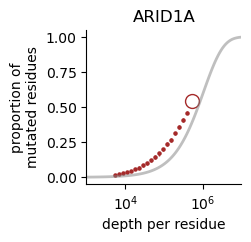

20it [00:00, 591.09it/s]0:00<00:03,  2.58it/s]


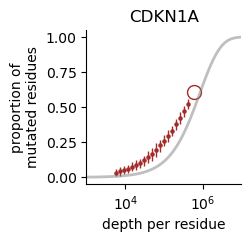

20it [00:00, 494.53it/s]0:00<00:02,  3.12it/s]


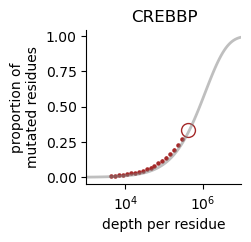

20it [00:00, 526.20it/s]0:00<00:02,  3.20it/s]


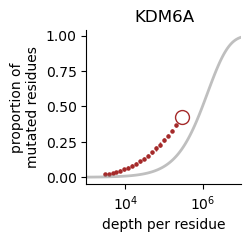

20it [00:00, 533.86it/s]0:01<00:01,  3.29it/s]


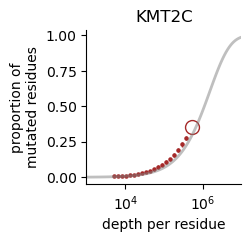

20it [00:00, 432.80it/s]0:01<00:01,  3.32it/s]


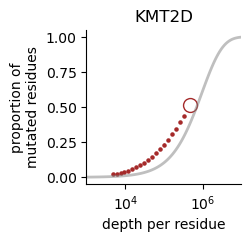

20it [00:00, 490.78it/s]0:01<00:01,  3.15it/s]


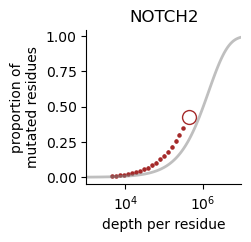

20it [00:00, 586.10it/s]0:02<00:00,  3.20it/s]


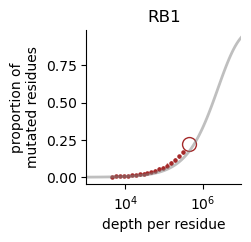

20it [00:00, 533.87it/s]0:02<00:00,  3.33it/s]


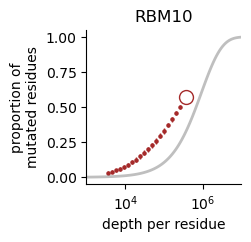

20it [00:00, 537.41it/s]0:02<00:00,  3.36it/s]


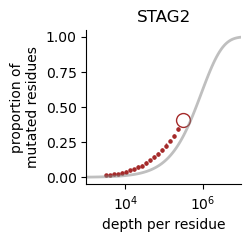

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


In [18]:
main_empirical('all_samples', sites='residue', logscale=False, genes_list = ['ARID1A', 'CDKN1A', 'CREBBP',
                                                                                'KDM6A', 'KMT2C', 'KMT2D',
                                                                                'NOTCH2', 'RB1', 'RBM10', 
                                                                                'STAG2'])

20it [00:00, 475.59it/s]0:00<?, ?it/s]


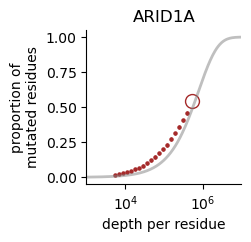

20it [00:00, 606.12it/s]0:00<00:02,  3.38it/s]


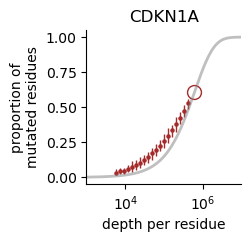

20it [00:00, 484.12it/s]0:00<00:02,  3.56it/s]


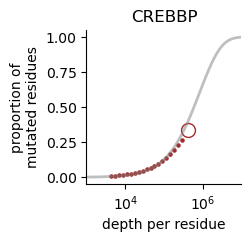

20it [00:00, 526.96it/s]0:00<00:02,  3.42it/s]


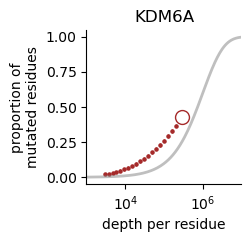

20it [00:00, 536.76it/s]0:01<00:01,  3.41it/s]


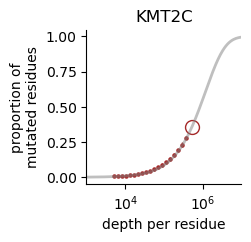

20it [00:00, 402.96it/s]0:01<00:01,  3.42it/s]


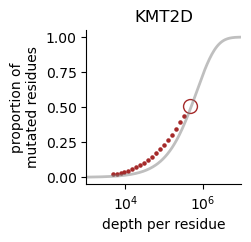

20it [00:00, 490.03it/s]0:01<00:01,  3.20it/s]


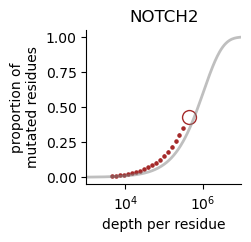

20it [00:00, 585.92it/s]0:02<00:00,  3.24it/s]


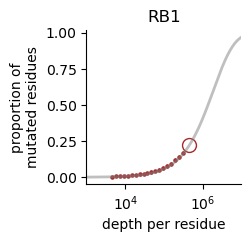

20it [00:00, 541.85it/s]0:02<00:00,  3.33it/s]


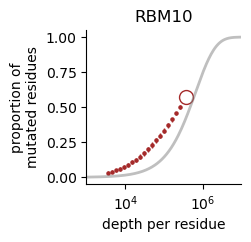

20it [00:00, 533.63it/s]0:02<00:00,  3.40it/s]


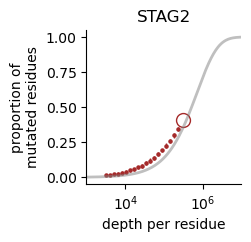

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


In [ ]:
main_empirical('all_samples', sites='residue', logscale=False, genes_list = ['ARID1A', 'CDKN1A', 'CREBBP',
                                                                                'KDM6A', 'KMT2C', 'KMT2D',
                                                                                'NOTCH2', 'RB1', 'RBM10', 
                                                                                'STAG2'])